### Import Libraries

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import json
import pickle
import seaborn as sns

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import preprocessing, utils
from tensorflow.keras.preprocessing.text import Tokenizer
import os 
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Concatenate, dot, Activation, Lambda, Input, Embedding, LSTM, Dense,Dot
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import re
import nltk
import string
import spacy
from sklearn.model_selection import train_test_split

from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras import backend as K

# Chatbot architecture

### 1.Load Text and apply Text Wrangling Techniques 

In [3]:
movie_utterances = pd.read_json('movie_utterances.jsonl', lines =True) #load json file in as dataframe
movie_utterances.shape #check dimension of dataframe

(304713, 8)

In [12]:
movie_utterances.head(6) #preview dataset

,id,conversation_id,text,speaker,meta,reply-to,timestamp,vectors
0,L1045,L1044,They do not!,u0,"{'movie_id': 'm0', 'parsed': [{'rt': 1, 'toks'...",L1044,NaT,[]
1,L1044,L1044,They do to!,u2,"{'movie_id': 'm0', 'parsed': [{'rt': 1, 'toks'...",None,NaT,[]
2,L985,L984,I hope so.,u0,"{'movie_id': 'm0', 'parsed': [{'rt': 1, 'toks'...",L984,NaT,[]
3,L984,L984,She okay?,u2,"{'movie_id': 'm0', 'parsed': [{'rt': 1, 'toks'...",None,NaT,[]
4,L925,L924,Let's go.,u0,"{'movie_id': 'm0', 'parsed': [{'rt': 0, 'toks'...",L924,NaT,[]
5,L924,L924,Wow,u2,"{'movie_id': 'm0', 'parsed': [{'rt': 0, 'toks'...",None,NaT,[]


In [5]:
movie_utterances.isnull().mean() #check for empty values

id                 0.000000
conversation_id    0.000000
text               0.000000
speaker            0.000000
meta               0.000000
reply-to           0.272706
timestamp          1.000000
vectors            0.000000
dtype: float64

In [7]:
movie_utterances[movie_utterances.isnull().any(axis=1)]#closer look at missing values

,id,conversation_id,text,speaker,meta,reply-to,timestamp,vectors
0,L1045,L1044,They do not!,u0,"{'movie_id': 'm0', 'parsed': [{'rt': 1, 'toks'...",L1044,NaT,[]
1,L1044,L1044,They do to!,u2,"{'movie_id': 'm0', 'parsed': [{'rt': 1, 'toks'...",None,NaT,[]
2,L985,L984,I hope so.,u0,"{'movie_id': 'm0', 'parsed': [{'rt': 1, 'toks'...",L984,NaT,[]
3,L984,L984,She okay?,u2,"{'movie_id': 'm0', 'parsed': [{'rt': 1, 'toks'...",None,NaT,[]
4,L925,L924,Let's go.,u0,"{'movie_id': 'm0', 'parsed': [{'rt': 0, 'toks'...",L924,NaT,[]
...,...,...,...,...,...,...,...,...
304708,L666371,L666369,Lord Chelmsford seems to want me to stay back ...,u9030,"{'movie_id': 'm616', 'parsed': [{'rt': 2, 'tok...",L666370,NaT,[]
304709,L666370,L666369,I'm to take the Sikali with the main column to...,u9034,"{'movie_id': 'm616', 'parsed': [{'rt': 1, 'tok...",L666369,NaT,[]
304710,L666369,L666369,"Your orders, Mr Vereker?",u9030,"{'movie_id': 'm616', 'parsed': [{'rt': 1, 'tok...",None,NaT,[]
304711,L666257,L666256,"Good ones, yes, Mr Vereker. Gentlemen who can ...",u9030,"{'movie_id': 'm616', 'parsed': [{'rt': 1, 'tok...",L666256,NaT,[]


In [13]:
movie_utterances.iloc[1] #missing value is the term None; which means the speaker is not responding , or they are the origin of the conversation

id                                                             L1044
conversation_id                                                L1044
text                                                     They do to!
speaker                                                           u2
meta               {'movie_id': 'm0', 'parsed': [{'rt': 1, 'toks'...
reply-to                                                        None
timestamp                                                        NaT
vectors                                                           []
Name: 1, dtype: object

In [14]:
# Select ratio
ratio = .40
 
rows_total = movie_utterances.shape[0]
new_data_size = int(rows_total*ratio)
 
# Split data into test and train
movie_utterances_new = movie_utterances.iloc[0:new_data_size]

#check shape of dataframe
movie_utterances_new.shape[0]



121885

In [15]:
''' iterate through dataframe based on condition
1. check if user is responding to previous user
2. if yes store respondee and original commentator in separate lists
3. check length of each list, ensure equal length
4. combine both in a list of tuples :[(speaker1,speaker2),(speaker1,speaker2),...]
5. if works rewrite as a user define function'''

i=0
speaker_1st = []
speaker_2nd = []

while i < len(movie_utterances_new)-1:
    if i + 1 < len(movie_utterances_new):
        if movie_utterances_new['reply-to'][i] == movie_utterances_new['id'][i+1]: #check if proceeding row is responding to user in previous row
            speaker_1st.append(movie_utterances_new['text'][i+1]) #add user from proceeding row comment
            speaker_2nd.append(movie_utterances_new['text'][i])#add user from previous row comment
            i+=1 #counter   
            
        elif pd.isna(movie_utterances_new['reply-to'].iloc[i]) or movie_utterances_new['reply-to'][i] == 'None': #check if user in proceeding row is starting a thread or convo
            #speaker_1st.append(utterances['id'][i+1])
            i+=1 #counter for while loop
            continue #if yes move to next row first if statement wil capture the info
        else:
            i+=1
            continue
        
print(len(speaker_1st))
print(len(speaker_2nd))
        
if len(speaker_1st) == len(speaker_2nd):
    movie_conversations = list(zip(speaker_1st, speaker_2nd))

88490
88490


In [16]:
movie_conversations[:6] #preview of text

[('They do to!', 'They do not!'),
 ('She okay?', 'I hope so.'),
 ('Wow', "Let's go."),
 ('No', "Okay -- you're gonna need to learn how to lie."),
 ('I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?',
  'No'),
 ('The "real you".', 'Like my fear of wearing pastels?')]

### 2. Text Preprocessing

In [17]:
''' Addressing word contractions'''

# Define a dictionary of contractions and their expansions
dict_word_contractions = {"don't": "do not","can't": "cannot","won't": "will not","wouldn't": "would not",
                          "shouldn't": "should not","couldn't": "could not","it's": "it is","i'm": "i am",
                          "you're": "you are","there's" : "there is","he's": "he is","she's": "she is",
                          "we're": "we are","they're": "they are","wasn't": "was not","weren't": "were not",
                          "hasn't": "has not","haven't": "have not","hadn't": "had not","mightn't": "might not",
                          "shan't": "shall not","mustn't": "must not","isn't":"is not","didn't":"did not","aren't":"are not",
                          "oughtn't":"ought not","needn't":"need not", "could've":"could have", "should've":"should have",
                          "would've":"would have","might've":"might have","i've":"i have","you've":"you have","we've":"we have",
                          "they've":"they have","i'll":"i will","you'll":"you will","he’ll":"he will","she’ll":"she will",
                          "it’ll":"it will","we’ll":"we will","they’ll":"they will","i’d":"i had","you’d":"you had",
                          "she’d":"she had","he’d":"he had","it'd":"it had", "we'd":"we had","they'd":"they had","that's":"that is",
                          "that’ve":"that have","that’d":"that would","which’ve":"which have","who’s":"who is","who’re":"who are",
                          "who’ve":"who have","who’d":"who had","who'll":"who will","what’s":"what is","what’re":"what are",
                          "what’ll":"what will","where’s":"where is","where’d":"where did","when’s":"when is","why’s":"why is",
                          "why’d":"why did","how’s":"how is","here’s":"here is","there’s":"there is","there’ll":"there will",
                          "there’d":"there had","someone’s":"someone is","somebody’s":"somebody is","no one’s":"no one is","nobody’s":"nobody is",
                          "something’s":"something is","nothing’s":"nothing is","let’s":"let us","ma’am":"madam","o'clock":"of the clock", "let's":"let us",
                          
}

# Create a regular expression pattern from the contractions dictionary
contractions_pattern = re.compile(r'\b(' + '|'.join(dict_word_contractions.keys()) + r')\b')

# Define a function to replace contractions using the pattern
def replace_contractions(text):
    word_contraction = lambda x: dict_word_contractions[x.group(0)] #locates contraction in dictionary
    result = re.sub(contractions_pattern, word_contraction,text) #finds and replace contraction in text with equivalent word/phrase
    return result
    
    

In [18]:
#test expand_contractions
text= "There's nothing to tell! He's just some guy I work with!"

replace_contractions(text.lower())

'there is nothing to tell! he is just some guy i work with!'

In [19]:
#Instances needed for preprocessing function
#spell_check = Speller(lang='en')
#lemmatizer = WordNetLemmatizer() #instance of lWordNetemmatizer
#stop_words = set(stopwords.words('english'))
#negation_words = [word for word in stop_words if (re.compile(r"\b\w+n[']t\b|\b\w+n'\b")).search(word)]
#stop_words_final = [word for word in stop_words if word not in negation_words] 
patterns = re.compile(pattern = "["u"\U0001F600-\U0001F64F"  # emoticons 
                                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                       "]+", flags = re.UNICODE)


nlp = spacy.load('en_core_web_sm')

In [70]:
def preprocessing(text):
    '''Preprocessing of text, steps covered:
    1. transform to lower case
    2. remove punctuations, numbers, emojis, unwanted characters
    3. tokenize text
    4. lemmatize text
    '''
        
    text = text.lower() #convert to lowercase

    text = replace_contractions(text) #replace word contractions
    #text= spell_check(text) #correct spelling errors
    text.translate(str.maketrans('', '', string.punctuation)) #remove punctuations
    text = re.sub(patterns,'', text)
    #text = re.sub('<!@.*?>', '', text) #remove unwanted characters 
    text = re.sub('[^A-Za-z0-9]+', ' ', text) #remove numbers
    text = re.sub(r"([.!?])", r" \1", text)
    text = re.sub(r"[^a-zA-Z.!?]+", r" ", text)
    text = re.sub(r"\s+", r" ", text).strip()
    
    text = nlp(text)

    # Perform lemmatization, removing stop words and non-alphabetic tokens
    cleaned = [token.lemma_ for token in text if token.is_alpha]
    
    #tokenized_words = word_tokenize(text) #tokenize text
    #cleaned = [lemmatizer.lemmatize(token) for token in tokenized_words] # #create list of cleaned lemmatized words
    
    
    return ' '.join(cleaned) # create list of strings
    

In [71]:
conversation_processed = [(preprocessing(speaker1), preprocessing(speaker2)) for speaker1, speaker2 in movie_conversations]   
conversation_processed[:6] #conversational text cleaned for use in model

[('they do to', 'they do not'),
 ('she okay', 'I hope so'),
 ('wow', 'let we go'),
 ('no', 'okay you be go to need to learn how to lie'),
 ('I be kid you know how sometimes you just become this persona and you do not know how to quit',
  'no'),
 ('the real you', 'like my fear of wear pastel')]

#### Save Portion of Data, that was cleaned as CSV

In [72]:
df_40 = pd.DataFrame(conversation_processed, columns=['Speaker1', 'Speaker2'])

# Save the DataFrame to a CSV file
df_40.to_csv('conversation_processed_0.4.csv', index=False)

In [20]:
# Load clean text data
df = pd.read_csv('conversation_processed_0.4.csv')

df.head(3)


,Speaker1,Speaker2
0,they do to,they do not
1,she okay,I hope so
2,wow,let we go


In [21]:
print(df[df.isna().any(axis=1)]) #display all missing values
df.fillna('no comment',inplace= True) #replace null values with no comment
print(df.isnull().sum())

                                         Speaker1  \
379                            hey great show huh   
1871                                          NaN   
3999                                          NaN   
8187                                          NaN   
8188   take hold of yourself what room be they in   
...                                           ...   
86751                  what s you depth cab three   
87489                                         NaN   
87490                    agne who mother superior   
87525                                         NaN   
87740                                         NaN   

                                                Speaker2  
379                                                  NaN  
1871                                             find it  
3999                                      fuck procedure  
8187   all right I will go up there and take care of ...  
8188                                                 NaN  
...      

In [22]:
# transform dataframe of clean text to list of tuples
conversation_processed = list(df.itertuples(index=False, name=None))

In [23]:
type(conversation_processed[:1][0][0])

str

In [24]:
speaker_1, speaker_2 = zip(*conversation_processed) # create two lists , speaker _1(question/statement), speaker_2 (response)

#add start and end tags on each sentence
start_tag = '<START>'
end_tag = '<END>'

speaker_1 = [f"{start_tag} {sentence} {end_tag}" for sentence in speaker_1]
speaker_2 = [f"{start_tag} {sentence} {end_tag}" for sentence in speaker_2]


#using keras tokenizer to transform words to numbers 
tokenizer = Tokenizer(num_words=12000)
tokenizer.fit_on_texts([sentence for text in conversation_processed for sentence in text]) #keras tokenize is assigning numeric value to words
#tokenizer is fit on to entire text so that there is consistency in numeric value assigned to words used in question answer pair  

#calculate size of vocabulary in text
VOCAB_SIZE =len(tokenizer.word_index )+1
print( 'VOCAB SIZE : {}'.format( VOCAB_SIZE ))


VOCAB SIZE : 24538


### Outlier of Sentence Sequences and Approach to managing outliers

* Data visualise distribution of sequence length using histogramm plot and boxplot
* Calcualtion of statiscal distribution values
   

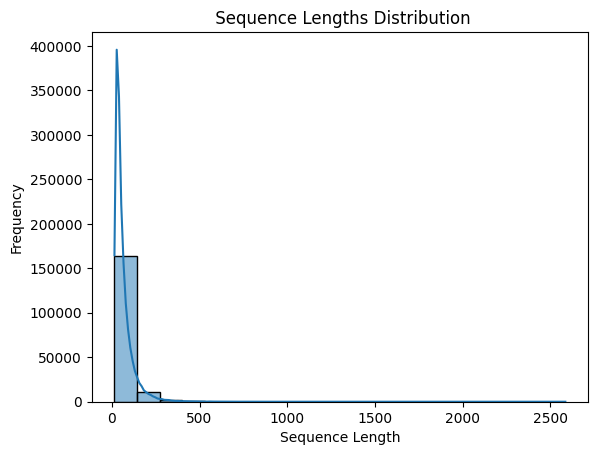

In [155]:
#visualize sequence length distribution , observe common sentence length , identify outliers
lengths_seq = [len(seq) for seq in speaker_1 + speaker_2]

sns.histplot(lengths_seq, bins=20, kde=True) #plot distribution of sequence lengths

plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title(' Sequence Lengths Distribution')

plt.show()

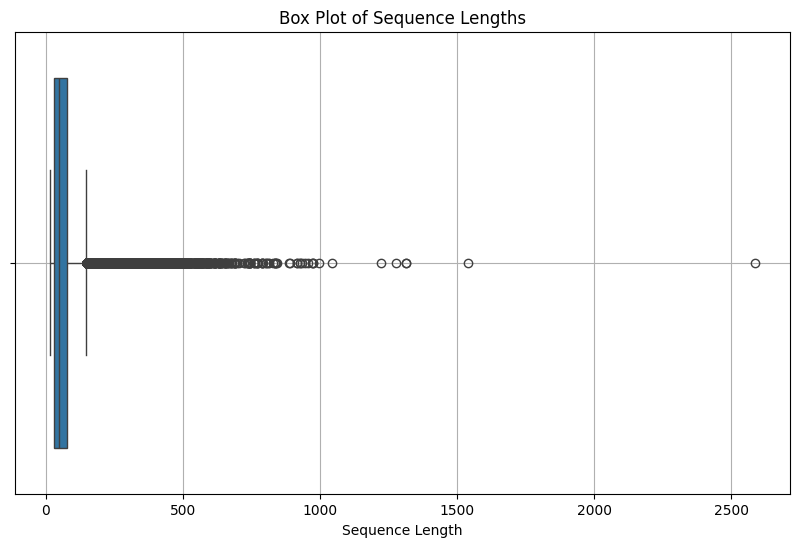

In [156]:
#visualize sequence length distribution , observe common sentence length , identify outliers using boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(x =lengths_seq)
plt.title('Box Plot of Sequence Lengths')

    
plt.xlabel('Sequence Length')
plt.grid(True)
plt.show()

In [157]:
#Statistical metrics for the sequence length
Q1 = np.percentile(lengths_seq, 25)  # 25th percentile
Q2 = np.percentile(lengths_seq, 50)  # 50th percentile
Q3 = np.percentile(lengths_seq, 75)  # 75th percentile
Percentile_90 = np.percentile(lengths_seq, 90)  # 75th percentile
Percentile_95 = np.percentile(lengths_seq, 95)  # 75th percentile

print(f"25th Percentile: {Q1}")
print(f"50th Percentile: {Q2}")
print(f"75th Percentile: {Q3}")
print(f"90th Percentile: {Percentile_90}")
print(f"95th Percentile: {Percentile_95}")

IQR = Q3-Q1
Upper_limit = Q3 + (1.5*IQR)
Lower_limit = Q1 - (1.5*IQR)
print(f"Sentence sequences above {Upper_limit} are considered outliers.")
print(f"Sentence sequence below {Lower_limit} are considered outliers.")

25th Percentile: 30.0
50th Percentile: 46.0
75th Percentile: 77.0
90th Percentile: 125.0
95th Percentile: 168.0
Sentence sequences above 147.5 are considered outliers.
Sentence sequence below -40.5 are considered outliers.


### Handling outliers

* From the statistical summary and visualization it is observed that 75% of the sequences have a length less than 77.
* The upper limit, beyond which values are considered outliers is 147.5, or 147 for purposes of sequence length, maxlength terms.
* To handle outliers the maxlength parameter for padding sequences will be set using 50th Percentile or the median value; this value represents 50 % of the dataset
  



In [158]:
#check that start_tag and end_tag were inserted
print(speaker_1[:3])
print(speaker_2[:3],'\n')


#check that start_tag and end_tag are in tokenizer.word_index
if 'start' in tokenizer.word_index:
    print("start_tag is in the word index.")
else:
    print("start_tag is not in the word index.")

if 'end' in tokenizer.word_index:
    print("end_tag is in the word index.")
else:
    print("end_tag is not in the word index.")

['<START> they do to <END>', '<START> she okay <END>', '<START> wow <END>']
['<START> they do not <END>', '<START> I hope so <END>', '<START> let we go <END>'] 

start_tag is in the word index.
end_tag is in the word index.


In [26]:
#split into training and test
speaker_1_train, speaker_1_test, speaker_2_train, speaker_2_test = train_test_split(speaker_1, speaker_2,
                                                                                    test_size=0.2, random_state=42)

## 2. Build Chatbot Architecture

### 2.a. Establish Encoder and Decoder values on Train split

In [198]:
#tokenize
tokenized_speaker_1st = tokenizer.texts_to_sequences(speaker_1_train)
tokenized_speaker_2nd = tokenizer.texts_to_sequences( speaker_2_train )

#caluclating maxlen value
#maxlen = max([len(seq) for seq in tokenized_speaker_1st + tokenized_speaker_2nd])
seqlength = int(np.percentile(lengths_seq, 75))
maxlen = seqlength
print(maxlen)

# encoder_input_data
padded_speaker_1st = pad_sequences( tokenized_speaker_1st , maxlen=maxlen , padding='post' ).astype(np.uint8)
encoder_input_data = np.array( padded_speaker_1st )
print( encoder_input_data.shape , maxlen )

# decoder_input_data
tokenized_speaker_2nd = tokenizer.texts_to_sequences( speaker_2_train )
padded_speaker_2nd = pad_sequences( tokenized_speaker_2nd , maxlen=maxlen , padding='post' ).astype(np.uint8)
decoder_input_data = np.array( padded_speaker_2nd )
print( decoder_input_data.shape , maxlen )

# decoder_output_data
tokenized_speaker_2 = tokenizer.texts_to_sequences( speaker_2_train )
for i in range(len(tokenized_speaker_2)):
    tokenized_speaker_2[i] = tokenized_speaker_2[i][1:]
padded_speaker_2 = pad_sequences(tokenized_speaker_2 , maxlen=maxlen , padding='post' ).astype(np.uint8)

#onehot_speaker_2 = utils.to_categorical( padded_speaker_2 , VOCAB_SIZE )
decoder_output_data = np.array( padded_speaker_2 )
print( decoder_output_data.shape )

77
(70792, 77) 77
(70792, 77) 77
(70792, 77)


### 2.b. Establish Encoder and Decoder values on Test split

In [199]:
# encoder_input_data
tokenized_speaker_1st = tokenizer.texts_to_sequences(speaker_1_test)
padded_speaker_1st = pad_sequences( tokenized_speaker_1st , maxlen=maxlen , padding='post',truncating= 'post' ).astype(np.uint8)
encoder_input_data_test = np.array( padded_speaker_1st )
print( encoder_input_data_test.shape , maxlen)

# decoder_input_data
tokenized_speaker_2nd = tokenizer.texts_to_sequences( speaker_2_test )
padded_speaker_2nd = pad_sequences( tokenized_speaker_2nd , maxlen=maxlen , padding='post',truncating ='post' ).astype(np.uint8)
decoder_input_data_test = np.array( padded_speaker_2nd )
print( decoder_input_data_test.shape , maxlen)

# decoder_output_data
tokenized_speaker_2 = tokenizer.texts_to_sequences( speaker_2_test )
for i in range(len(tokenized_speaker_2)):
    tokenized_speaker_2[i] = tokenized_speaker_2[i][1:]
padded_speaker_2 = pad_sequences( tokenized_speaker_2 , maxlen=maxlen , padding='post', truncating = 'post' ).astype(np.uint8)

#onehot_speaker_2 = utils.to_categorical( padded_speaker_2 , VOCAB_SIZE )
decoder_output_data_test = np.array(padded_speaker_2)
print( decoder_output_data_test.shape )

(17698, 77) 77
(17698, 77) 77
(17698, 77)


### 2.c. Define Attention Layer

In [200]:
def attn_layer(enc_out, dec_out):
    #calculate the attention scores
    attn_score = Dot(axes=[2, 2])([dec_out, enc_out])
    attention_weights = Activation('softmax')(attn_score)

    #calculate the context vector
    context_vector = dot([attention_weights, enc_out],axes=[2,1])
    
    return context_vector, attention_weights

### 2.d. Define Encoder, Decoder and Model with Attention Layer included

In [234]:
hidden_dim = 128
output_dim = 64

#Encoder input and output values
encoder_inputs = Input(shape=(maxlen , ))
encoder_embedding_layer = Embedding(VOCAB_SIZE, output_dim , mask_zero=True )
encoder_embedding = encoder_embedding_layer(encoder_inputs)
encoder_lstm = LSTM( hidden_dim , return_state=True,return_sequences=True, dropout = 0.5)#, recurrent_dropout = 0.5 )
encoder_outputs , state_h , state_c = encoder_lstm(encoder_embedding )
encoder_states = [ state_h , state_c ]
print( encoder_inputs.shape , maxlen)#check dimension shape
print( encoder_outputs.shape , maxlen)#check dimension shape

#Decoder input and output values
decoder_inputs = Input(shape=( maxlen ,  ))
decoder_embedding_layer = Embedding(VOCAB_SIZE, output_dim , mask_zero=True)
decoder_embedding= decoder_embedding_layer(decoder_inputs)
decoder_lstm = LSTM( hidden_dim , return_state=True , return_sequences=True , dropout = 0.5)#, recurrent_dropout = 0.5)
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )

print( decoder_inputs.shape , maxlen)#check dimension shape
print( decoder_outputs.shape , maxlen)#check dimension shape

#Calculate the attention context vector values
context_vector, attention_weights = attn_layer(encoder_outputs, decoder_outputs)
decoder_combined_context = Concatenate(axis = -1)([decoder_outputs, context_vector])
decoder_dense = Dense(VOCAB_SIZE , activation= 'softmax' )
deco_outputs = decoder_dense(decoder_combined_context)

#Define model and Compile
model = Model([encoder_inputs, decoder_inputs], deco_outputs )
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.00005), loss= tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])

model.summary()

(None, 77) 77
(None, 77, 128) 77
(None, 77) 77
(None, 77, 128) 77
Encoder output shape: (None, 77, 128)
Decoder output shape: (None, 77, 128)
Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 77)]         0           []                               
                                                                                                  
 input_36 (InputLayer)          [(None, 77)]         0           []                               
                                                                                                  
 embedding_34 (Embedding)       (None, 77, 64)       1570432     ['input_35[0][0]']               
                                                                                                  
 embedding_35 (Embedding)       (None, 77, 64)  

### 3. Train and Test Chatbot Model

In [27]:
#Check that tensorflow is recognizing the GPU
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
Num GPUs Available: 1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [236]:
#implement early stoping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [237]:
#language model
chat_train_model = model.fit([encoder_input_data, decoder_input_data], decoder_output_data, batch_size= 64, epochs=50,
          validation_data=([encoder_input_data_test, decoder_input_data_test], decoder_output_data_test),callbacks =[early_stopping])

Epoch 1/50
1107/1107 [==============================] - 418s 370ms/step - loss: 1.0293 - accuracy: 0.0825 - val_loss: 0.7811 - val_accuracy: 0.0900
Epoch 2/50
1107/1107 [==============================] - 415s 375ms/step - loss: 0.7767 - accuracy: 0.0988 - val_loss: 0.7741 - val_accuracy: 0.1261
Epoch 3/50
1107/1107 [==============================] - 418s 378ms/step - loss: 0.7615 - accuracy: 0.1476 - val_loss: 0.7475 - val_accuracy: 0.1640
Epoch 4/50
1107/1107 [==============================] - 414s 374ms/step - loss: 0.7366 - accuracy: 0.1705 - val_loss: 0.7310 - val_accuracy: 0.1721
Epoch 5/50
1107/1107 [==============================] - 416s 376ms/step - loss: 0.7273 - accuracy: 0.1728 - val_loss: 0.7248 - val_accuracy: 0.1740
Epoch 6/50
1107/1107 [==============================] - 421s 380ms/step - loss: 0.7226 - accuracy: 0.1765 - val_loss: 0.7206 - val_accuracy: 0.1790
Epoch 7/50
1107/1107 [==============================] - 422s 381ms/step - loss: 0.7193 - accuracy: 0.1792 - val_

In [242]:
#save model for future use; save three different ways to single out 1 before final submisison
model.save( 'model_50b.h5' ) 
model.save( 'model_50b.keras' )

# Save the tokenizer to a file
with open('tokenizer_50b.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

# save weights
#model_50b_weights = model.get_weights()
model.save_weights("weights_50b.h5")
model.save_weights("weights_50b.keras")
#new_model.set_weights(old_weights)
    


In [252]:
#save decoder_embedding weights
 
decoder_embedding_layer_50b = model.get_layer(name='embedding_35') #getting the decoder embedding layer

weights = decoder_embedding_layer_50b.get_weights() #get the weights

np.save('decoder_embedding_layer_50b.npy', weights[0]) #save the weights

#the approaches below were not working
#decoder_embedding_layer_50b.save_weights('decoder_embedding_weights_50b.h5')
#decoder_embedding_layer_50b.save_weights('decoder_embedding_weights_50b.keras')

### 3.a. Training observations
* The maxlen parameter for padding sequences was changed form the max length of sequences which was 482; this number was extremely high and resulted in the model not being able to train because of the computational power needed, the local machine used did not have enough resource or graphical power
* The maxlen value was changed to the mean lenght of the sequences; however mean values are heavily impacted by outliers and this was later observed in how the model trained.
* for one the time each epoch for training each batch was just over 60 seconds and the model completed training before the epoch value set.
* this was initially thought to be occuring due to the early_stopping patience value of 3 which was set, however when this was changed  to 9 it had no impact on the model's ability to continue learning beyond 10 epochs
* all experiments were run with output_dim and hidden_dim = 150

 observations when maxlen changed to median value and patience = 3, batch_size = , epoch = 15, output_dim and hidden_dim = 150
 All the runs below occured with patience = 3, maxlen = median seq length(46), learning rate 0.001
 * graph suggests modelling is underfitting and could benefit from increased epochs
 * will attemtp with epoch at 25 and hidden_dim and output_dim = 200; the model overfit at 25 epoch and 128 batch size, Early_Stopping(Patience =3),maxlen = median(46),hidden_dim =200 , output_dim = 200
 * will attempt now with hidden_dim= 128 and output_dim = 64, batch_size= 128, epochs=25; still underfitting will train will 100 epoch
 * will attempt now with hidden_dim= 128 and output_dim = 64, batch_size= 256, epochs=100; no change from previous run, got worse strangely and stopped at 20 epoch, stil underfitting
 * will attempt now with hidden_dim= 128 and output_dim = 64, batch_size= 32, epochs=100: no improvements stopped at epoch 13, underfitting


For this set of experiments will use a smaller learning rate(0.0005), will use a maxlen(75th percentile), use lstm(hidden_dim =256), batch size(64), embedding layer(output_dim=64), early_stopping(patience =9)
* first run done at 25 epoch with above changes; model overfits
* will run again at 25 epoch, lstm(hidden_dim =128), early_stopping(patience = 6) and learning_rate(0.0003); significant reduction in overfitting but still overfits
* ---------------- All Experiments above this line were executed with a drop out of 0.5--------------------------------------------------------
* will run again at 25 epoch lstm(hidden_dim =128), early_stopping(patience = 5) and learning_rate(0.0002), dropout (0.5); This model improved even more than previous, now the loss curve between train and validation is much closer suggesting minimal overfitting
* will run again at 25 epoch lstm(hidden_dim =128), early_stopping(patience = 4) and learning_rate(0.0002), dropout (0.5); so the model underfit greatly..at best patience should not be lower than 5.
* will run again at 25 epoch lstm(hidden_dim =128), early_stopping(patience = 5) and learning_rate(0.0001), dropout (0.5); perfect both curves run together

--------------------------------------------Last run saw good performance--------------------------------------------------------------------------
* will run again at 50 epoch lstm(hidden_dim =128), early_stopping(patience = 5) and learning_rate(0.0001), dropout (0.5): this model show significant underfitting.
* will run again at 50 epoch lstm(hidden_dim =128), early_stopping(patience =5) and learning_rate(0.00007), dropout (0.5): the model improved greatly slightly overfitting towards the end of the 50 epochs
* will run again at 50 epoch lstm(hidden_dim =128), early_stopping(patience =5) and learning_rate(0.00005), dropout (0.5)- this model performed perfectly and was saved
 

### 3.b. Model Evaluation

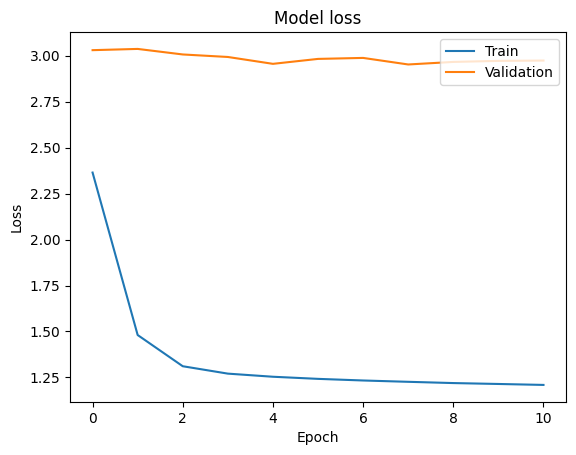

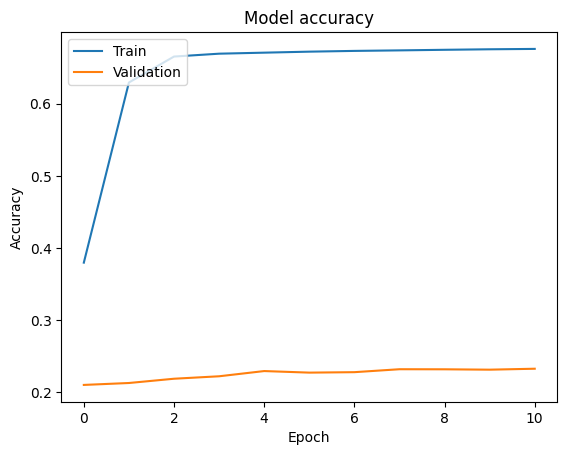

In [130]:
#Experiment # 2
#plotting model training loss and validation loss at 150 epoch and 64 batch size
plt.plot(chat_train_model.history['loss'])
plt.plot(chat_train_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting training & validation accuracy values
plt.plot(chat_train_model.history['accuracy'])
plt.plot(chat_train_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

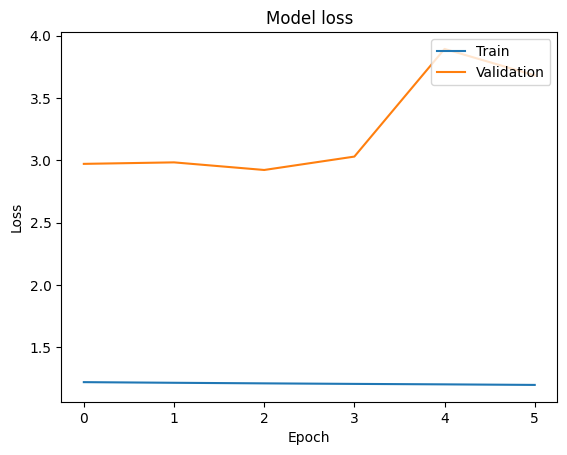

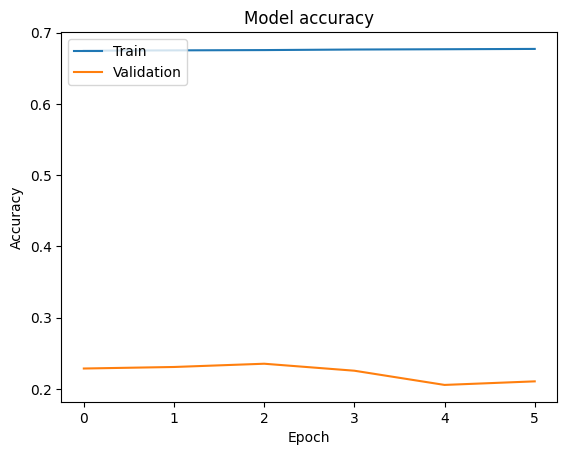

In [132]:
#Experiment #3
#plotting model training loss and validation loss at 100 epoch and 50 batch size
plt.plot(chat_train_model.history['loss'])
plt.plot(chat_train_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting training & validation accuracy values
plt.plot(chat_train_model.history['accuracy'])
plt.plot(chat_train_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

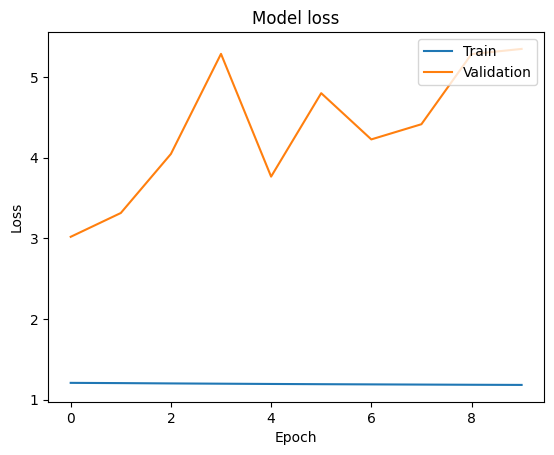

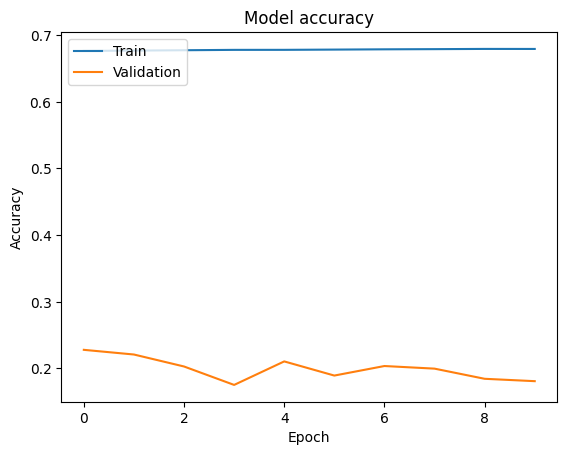

In [135]:
#Experiment #4
#plotting model training loss and validation loss at 100 epoch and 50 batch size, Early_Stopping(Patience =9)
plt.plot(chat_train_model.history['loss'])
plt.plot(chat_train_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting training & validation accuracy values
plt.plot(chat_train_model.history['accuracy'])
plt.plot(chat_train_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

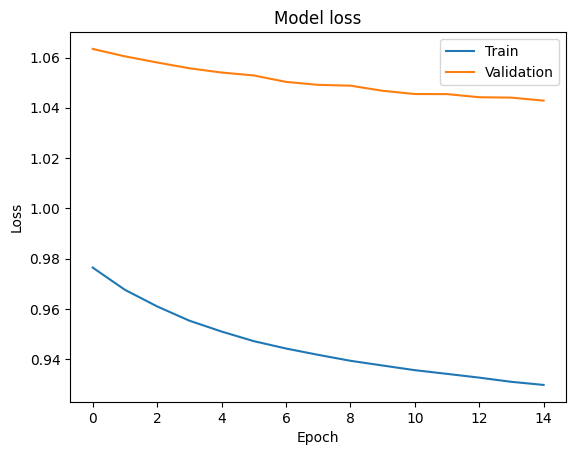

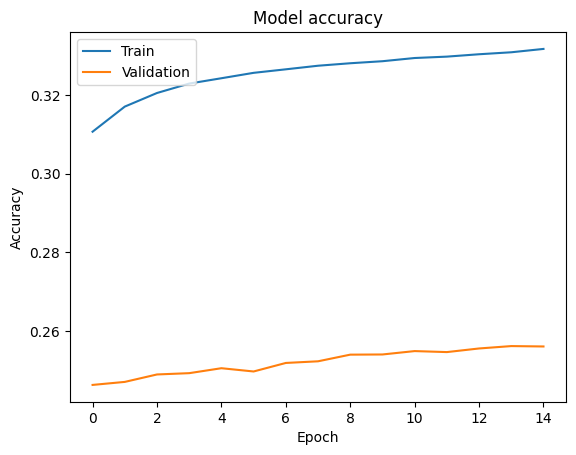

In [179]:
#Experiment #5
#plotting model training loss and validation loss at 15 epoch and 256 batch size, Early_Stopping(Patience =3),maxlen = median(46)
#hidden_dim =150 , output_dim = 150
plt.plot(chat_train_model.history['loss'])
plt.plot(chat_train_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting training & validation accuracy values
plt.plot(chat_train_model.history['accuracy'])
plt.plot(chat_train_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

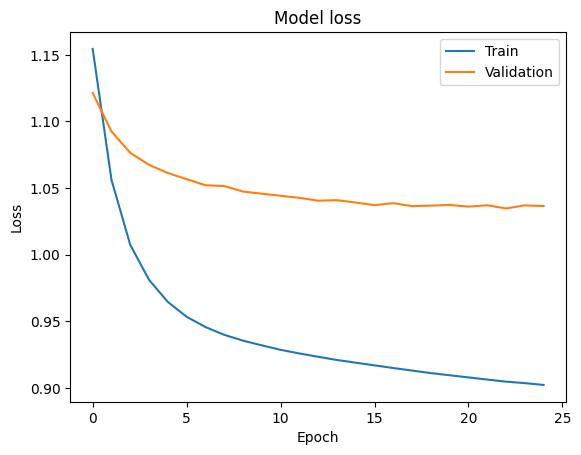

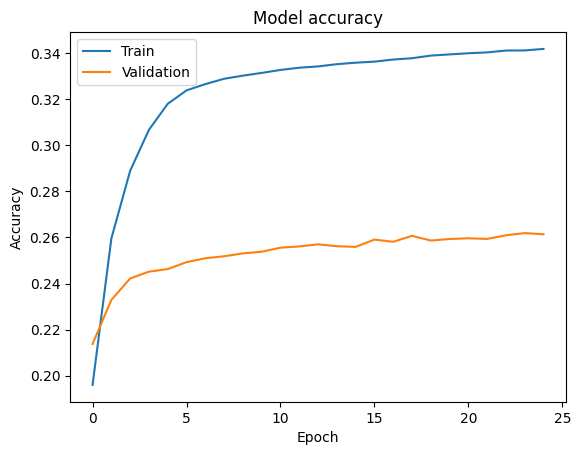

In [185]:
#Experiment #6
#plotting model training loss and validation loss at 25 epoch and 128 batch size, Early_Stopping(Patience =3),maxlen = median(46)
#hidden_dim =200 , output_dim = 200
plt.plot(chat_train_model.history['loss'])
plt.plot(chat_train_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting training & validation accuracy values
plt.plot(chat_train_model.history['accuracy'])
plt.plot(chat_train_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

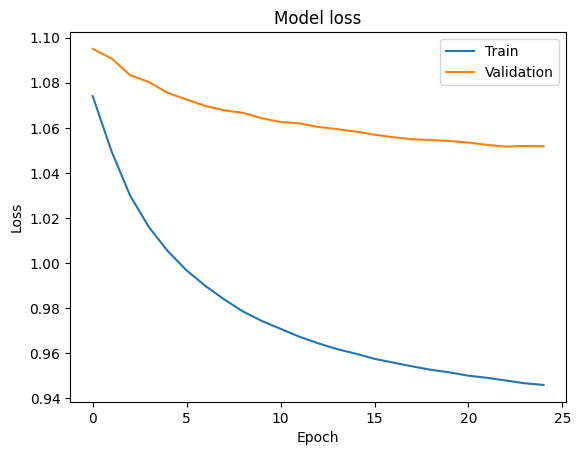

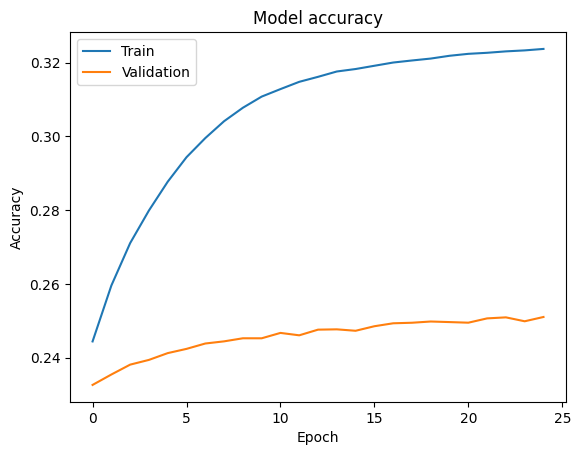

In [193]:
#Experiment #7
#plotting model training loss and validation loss at 25 epoch and 256 batch size, Early_Stopping(Patience =3),maxlen = median(46)
#hidden_dim =128 , output_dim = 64
plt.plot(chat_train_model.history['loss'])
plt.plot(chat_train_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting training & validation accuracy values
plt.plot(chat_train_model.history['accuracy'])
plt.plot(chat_train_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

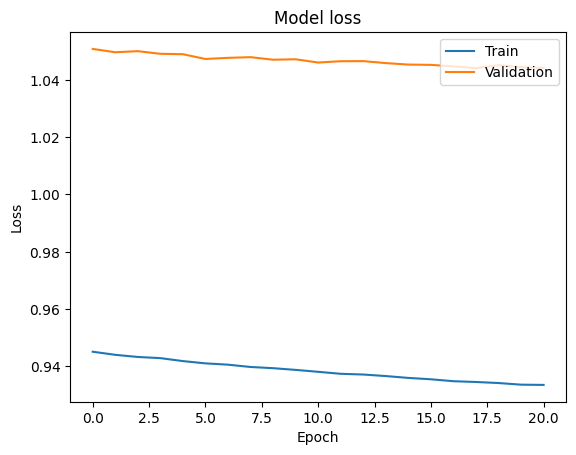

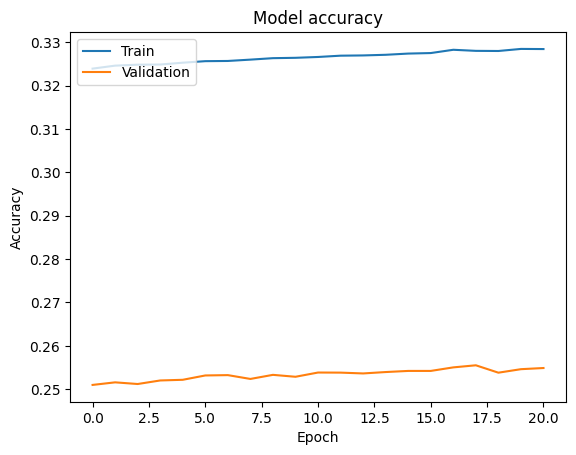

In [195]:
#Experiment #8
#plotting model training loss and validation loss at 100 epoch and 256 batch size, Early_Stopping(Patience =3),maxlen = median(46)
#hidden_dim =128 , output_dim = 64
plt.plot(chat_train_model.history['loss'])
plt.plot(chat_train_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting training & validation accuracy values
plt.plot(chat_train_model.history['accuracy'])
plt.plot(chat_train_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

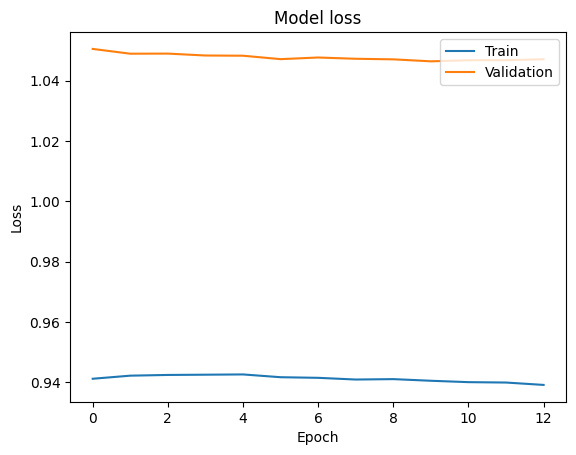

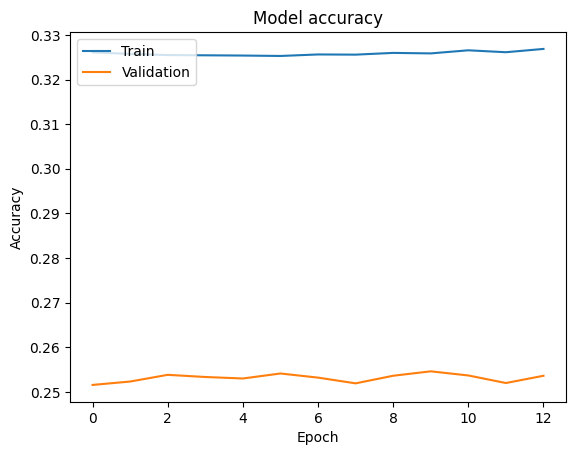

In [197]:
#Experiment #9
#plotting model training loss and validation loss at 100 epoch and 32 batch size, Early_Stopping(Patience =3),maxlen = median(46)
#hidden_dim =128 , output_dim = 64
plt.plot(chat_train_model.history['loss'])
plt.plot(chat_train_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting training & validation accuracy values
plt.plot(chat_train_model.history['accuracy'])
plt.plot(chat_train_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

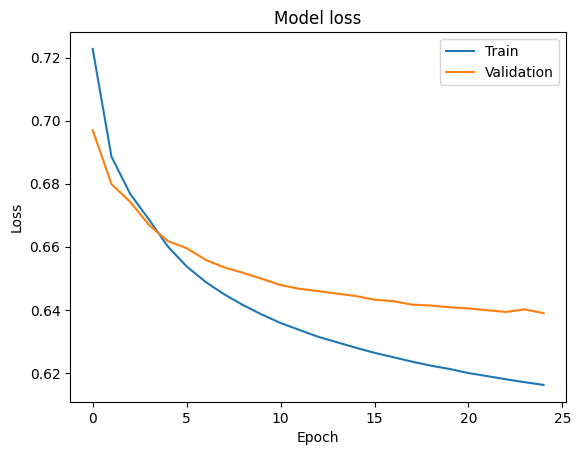

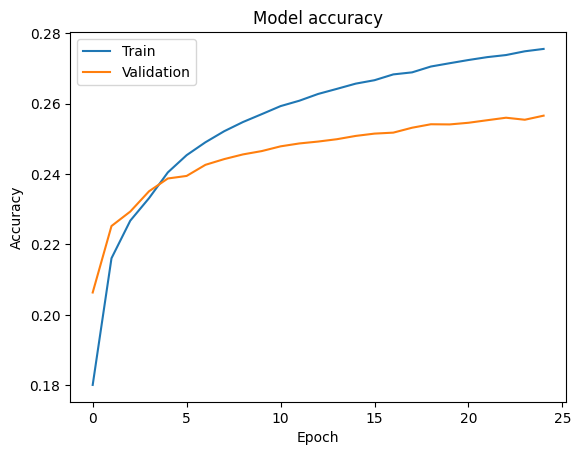

In [207]:
#Experiment #10
#plotting model training loss and validation loss at learning rate(0.0005), 
#will use a maxlen(75th percentile), use lstm(hidden_dim =256), batch size(64), 
#embedding layer(output_dim=64), early_stopping(patience =9)

plt.plot(chat_train_model.history['loss'])
plt.plot(chat_train_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting training & validation accuracy values
plt.plot(chat_train_model.history['accuracy'])
plt.plot(chat_train_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

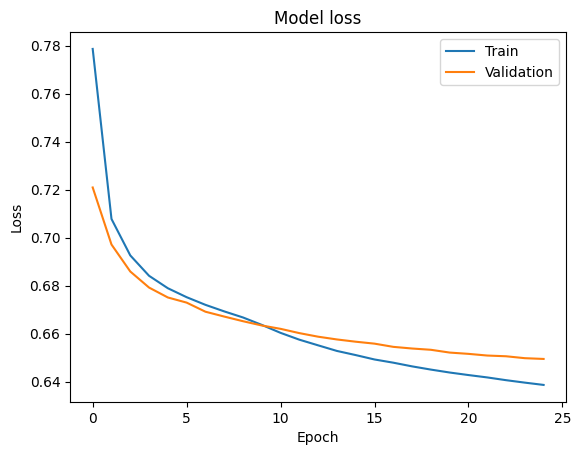

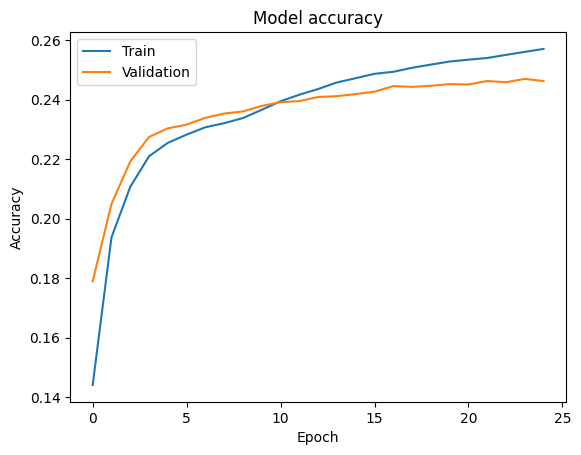

In [212]:
#Experiment #11
#plotting model training loss and validation loss at learning rate(0.0003), 
#will use a maxlen(75th percentile), use lstm(hidden_dim =128), batch size(64), 
#embedding layer(output_dim=64), early_stopping(patience =6)

plt.plot(chat_train_model.history['loss'])
plt.plot(chat_train_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting training & validation accuracy values
plt.plot(chat_train_model.history['accuracy'])
plt.plot(chat_train_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

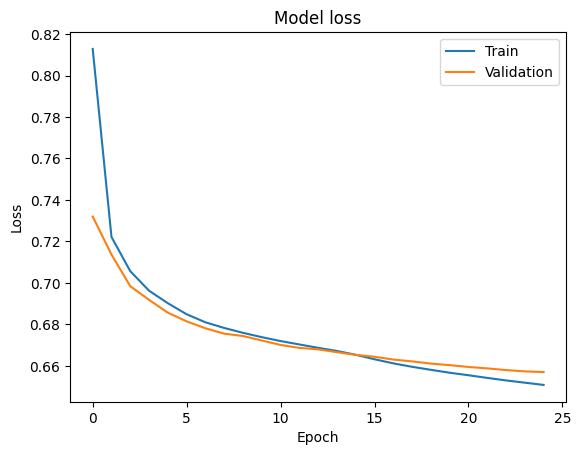

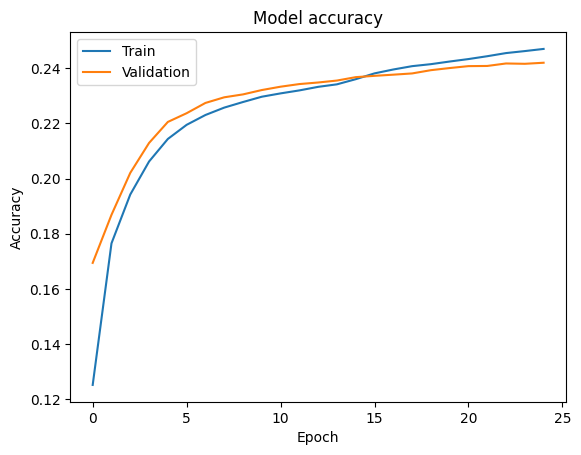

In [217]:
#Experiment #12
#plotting model training loss and validation loss at learning rate(0.0002), 
#will use a maxlen(75th percentile), use lstm(hidden_dim =128), batch size(64), 
#embedding layer(output_dim=64), early_stopping(patience =5)

plt.plot(chat_train_model.history['loss'])
plt.plot(chat_train_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting training & validation accuracy values
plt.plot(chat_train_model.history['accuracy'])
plt.plot(chat_train_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

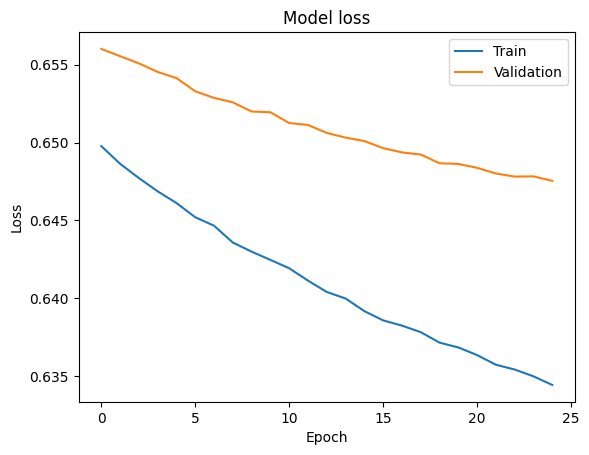

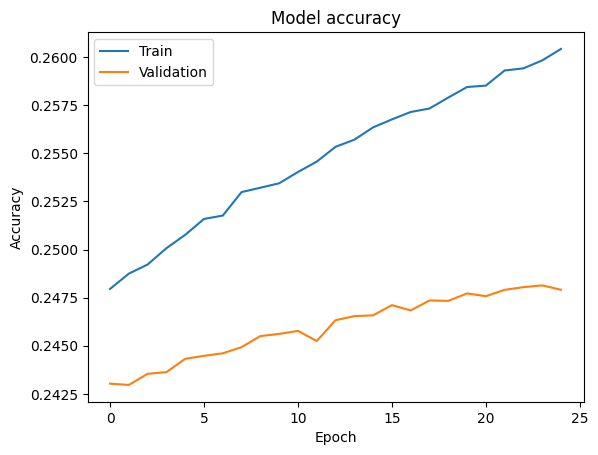

In [221]:
#Experiment #13
#plotting model training loss and validation loss at learning rate(0.0002), 
#will use a maxlen(75th percentile), use lstm(hidden_dim =128), batch size(64), 
#embedding layer(output_dim=64), early_stopping(patience =4)

plt.plot(chat_train_model.history['loss'])
plt.plot(chat_train_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting training & validation accuracy values
plt.plot(chat_train_model.history['accuracy'])
plt.plot(chat_train_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

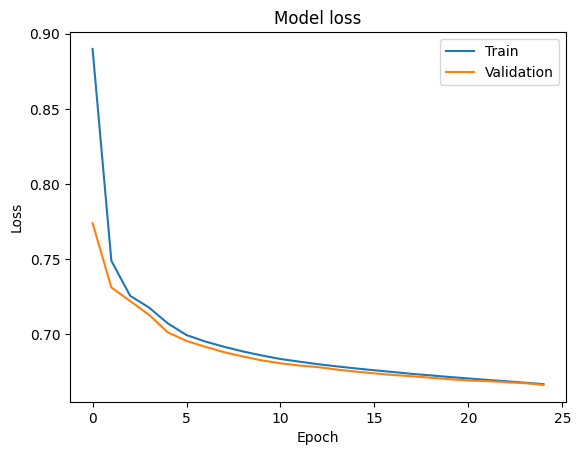

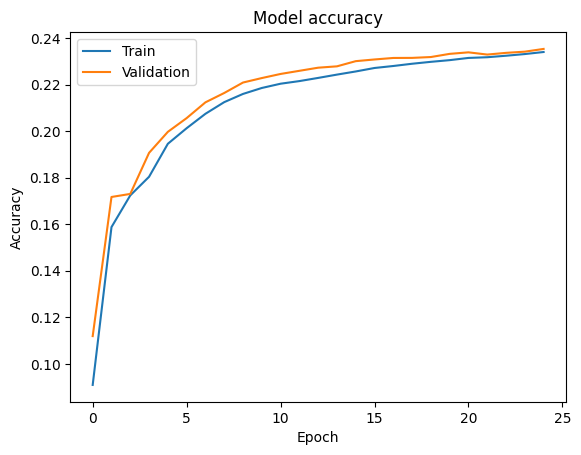

In [226]:
#Experiment #14
#plotting model training loss and validation loss at learning rate(0.0001), 
#will use a maxlen(75th percentile), use lstm(hidden_dim =128), batch size(64), 
#embedding layer(output_dim=64), early_stopping(patience =5)

plt.plot(chat_train_model.history['loss'])
plt.plot(chat_train_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting training & validation accuracy values
plt.plot(chat_train_model.history['accuracy'])
plt.plot(chat_train_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

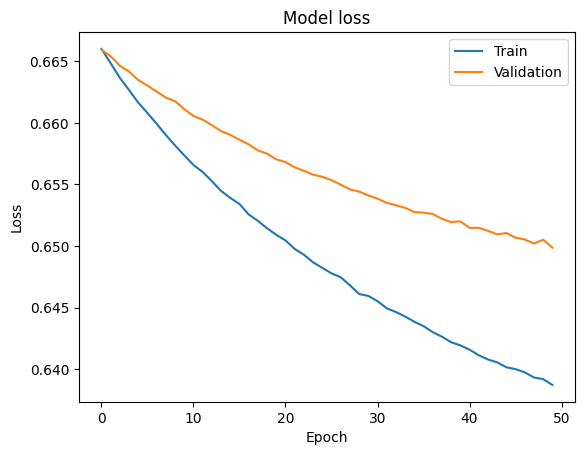

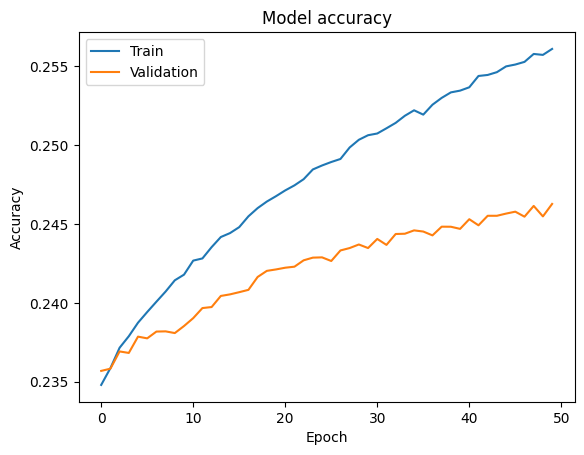

In [228]:
#Experiment #15
#plotting model training loss and validation loss at learning rate(0.0001), 
#will use a maxlen(75th percentile), use lstm(hidden_dim =128), batch size(64), 
#embedding layer(output_dim=64), early_stopping(patience =5), epoch = 50

plt.plot(chat_train_model.history['loss'])
plt.plot(chat_train_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting training & validation accuracy values
plt.plot(chat_train_model.history['accuracy'])
plt.plot(chat_train_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

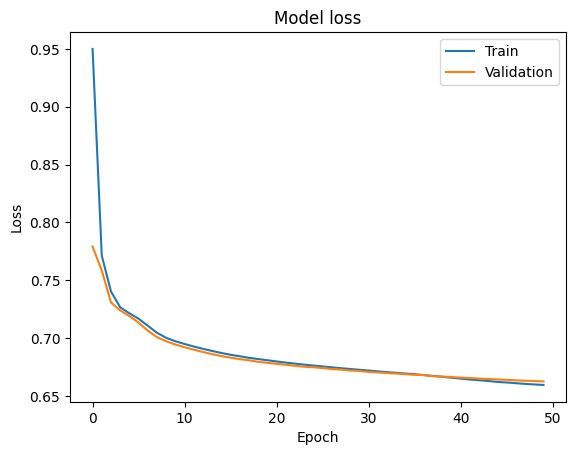

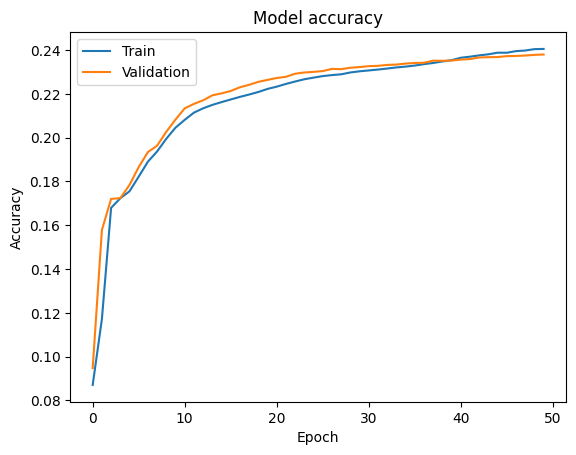

In [233]:
#Experiment #16
#plotting model training loss and validation loss at learning rate(0.00007), 
#will use a maxlen(75th percentile), use lstm(hidden_dim =128), batch size(64), 
#embedding layer(output_dim=64), early_stopping(patience =5), epoch = 50

plt.plot(chat_train_model.history['loss'])
plt.plot(chat_train_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting training & validation accuracy values
plt.plot(chat_train_model.history['accuracy'])
plt.plot(chat_train_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

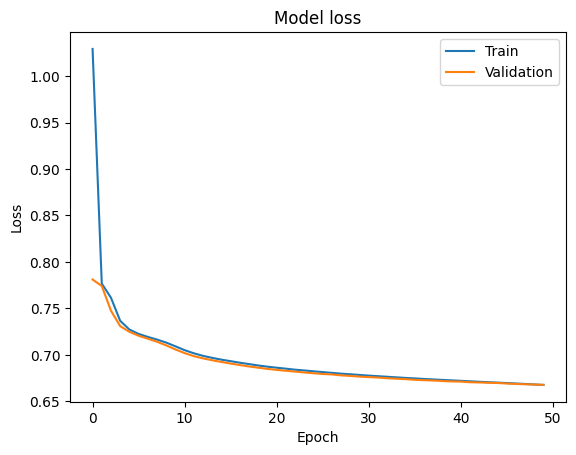

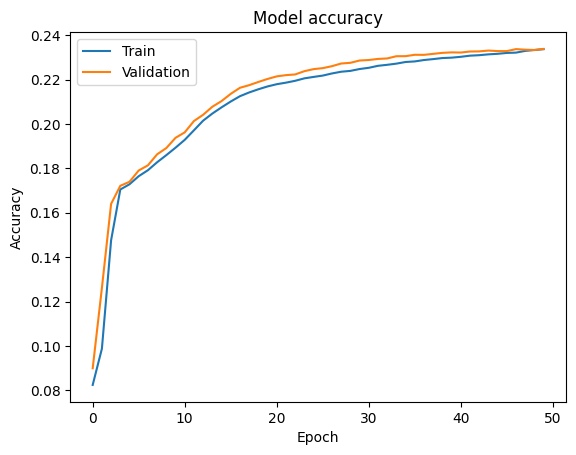

In [238]:
#Experiment #17
#plotting model training loss and validation loss at learning rate(0.00005), 
#will use a maxlen(75th percentile), use lstm(hidden_dim =128), batch size(64), 
#embedding layer(output_dim=64), early_stopping(patience =5), epoch = 50

plt.plot(chat_train_model.history['loss'])
plt.plot(chat_train_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting training & validation accuracy values
plt.plot(chat_train_model.history['accuracy'])
plt.plot(chat_train_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Evaluate the saved model on unseen data

In [253]:
#test data 
movie_utterances_test = movie_utterances.iloc[new_data_size: ]
movie_utterances_test.shape[0]

182828

In [257]:
movie_utterances_test = movie_utterances_test.reset_index(drop=True) #reset the index
movie_utterances_test.head()

,id,conversation_id,text,speaker,meta,reply-to,timestamp,vectors
0,L23559,L23558,No.,u3584,"{'movie_id': 'm236', 'parsed': [{'rt': 0, 'tok...",L23558,NaT,[]
1,L23558,L23558,I'm getting nowhere. The whole area around th...,u3582,"{'movie_id': 'm236', 'parsed': [{'rt': 2, 'tok...",None,NaT,[]
2,L23528,L23527,The computer just translated the goddamn messa...,u3584,"{'movie_id': 'm236', 'parsed': [{'rt': 3, 'tok...",L23527,NaT,[]
3,L23527,L23527,What? What was that?,u3582,"{'movie_id': 'm236', 'parsed': [{'rt': 0, 'tok...",None,NaT,[]
4,L23512,L23509,I'm trying.,u3582,"{'movie_id': 'm236', 'parsed': [{'rt': 2, 'tok...",L23511,NaT,[]


In [259]:
''' iterate through dataframe based on condition
1. check if user is responding to previous user
2. if yes store respondee and original commentator in separate lists
3. check length of each list, ensure equal length
4. combine both in a list of tuples :[(speaker1,speaker2),(speaker1,speaker2),...]
5. if works rewrite as a user define function'''

i=0
speaker_1st_test = []
speaker_2nd_test = []

while i < len(movie_utterances_test)-1:
    if i + 1 < len(movie_utterances_test):
        if movie_utterances_test['reply-to'][i] == movie_utterances_test['id'][i+1]: #check if proceeding row is responding to user in previous row
            speaker_1st_test.append(movie_utterances_test['text'][i+1]) #add user from proceeding row comment
            speaker_2nd_test.append(movie_utterances_test['text'][i])#add user from previous row comment
            i+=1 #counter   
            
        elif pd.isna(movie_utterances_test['reply-to'].iloc[i]) or movie_utterances_test['reply-to'][i] == 'None': #check if user in proceeding row is starting a thread or convo
            #speaker_1st.append(utterances['id'][i+1])
            i+=1 #counter for while loop
            continue #if yes move to next row first if statement wil capture the info
        else:
            i+=1
            continue
        
print(len(speaker_1st_test))
print(len(speaker_2nd_test))
        
if len(speaker_1st_test) == len(speaker_2nd_test):
    movie_conversations_test = list(zip(speaker_1st_test, speaker_2nd_test))

133125
133125


In [260]:
conversation_processed_test = [(preprocessing(speaker1), preprocessing(speaker2)) for speaker1, speaker2 in movie_conversations_test]   
conversation_processed_test[:6]

[('I be get nowhere the whole area around the pyramid be dead to transmission I think we should go after they',
  'no'),
 ('what what be that',
  'the computer just translate the goddamn message it be not an s o s it be a warning'),
 ('can you get they back', 'I be try'),
 ('I have completely lose their signal', 'can you get they back'),
 ('now what s wrong', 'I have completely lose their signal'),
 ('okay',
  'and you and I will bag it and then we ll take it to the ventral air lock get it')]

In [261]:
df_60 = pd.DataFrame(conversation_processed_test, columns=['Speaker1', 'Speaker2'])

# Save the DataFrame to a CSV file
df_60.to_csv('conversation_processed_0.6.csv', index=False)

# Start here when Kernel is cleared

In [37]:
# Load clean text data
conversation_processed_test = pd.read_csv('conversation_processed_0.6.csv')

#df.head(3)

In [38]:
conversation_processed_test.head(1)

,Speaker1,Speaker2
0,I be get nowhere the whole area around the pyr...,no


In [43]:
# Select ratio
ratio = .05
 
rows_total = conversation_processed_test.shape[0]
new_size = int(rows_total*ratio)
 
# Split data into test and train
conversation_processed_test_new = conversation_processed_test.iloc[0:new_size]

conversation_processed_test_new.shape[0] #number of records in the dataset

6656

In [44]:
print(conversation_processed_test_new[conversation_processed_test_new.isna().any(axis=1)]) #display all missing values
conversation_test = conversation_processed_test_new.copy()
conversation_test.fillna('no comment',inplace= True) #replace null values with no comment
print(conversation_test.isnull().sum())

Empty DataFrame
Columns: [Speaker1, Speaker2]
Index: []
Speaker1    0
Speaker2    0
dtype: int64


In [45]:
# transform dataframe of clean text to list of tuples
conversation_test = list(conversation_test.itertuples(index=False, name=None))


In [46]:
# Load the tokenizer from the file
with open('tokenizer_50b.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

In [47]:
speaker_1test, speaker_2test = zip(*conversation_test) # create two lists , speaker _1(question/statement), speaker_2 (response)

#add start and end tags on each sentence
start_tag = '<START>'
end_tag = '<END>'

speaker_1test = [f"{start_tag} {sentence} {end_tag}" for sentence in speaker_1test]
speaker_2test = [f"{start_tag} {sentence} {end_tag}" for sentence in speaker_2test]


#using keras tokenizer to transform words to numbers 
#tokenizer = Tokenizer(num_words=12000)
tokenizer.fit_on_texts([sentence for text in conversation_processed_test for sentence in text]) #keras tokenize is assigning numeric value to words
#tokenizer is fit on to entire text so that there is consistency in numeric value assigned to words used in question answer pair  

#calculate size of vocabulary in text
#VOCAB_SIZE =len(tokenizer.word_index )+1
#print( 'VOCAB SIZE : {}'.format( VOCAB_SIZE ))

In [48]:
model_test = load_model('model_50b.h5') #load best model

In [57]:
#tokenize
maxlen=77
tokenized_speaker_1st_test = tokenizer.texts_to_sequences(speaker_1test)
tokenized_speaker_2nd_test = tokenizer.texts_to_sequences( speaker_2test )

#pad speaker 1 and 2 sequences
padded_speaker_1st_test = pad_sequences( tokenized_speaker_1st_test , maxlen=maxlen , padding='post' ).astype(np.uint8) #use same maxlen as training

padded_speaker_2nd_test = pad_sequences( tokenized_speaker_2nd_test , maxlen=maxlen , padding='post' ).astype(np.uint8)


tokenized_speaker_2_test = tokenizer.texts_to_sequences( speaker_2test )
for i in range(len(tokenized_speaker_2_test)):
    tokenized_speaker_2_test[i] = tokenized_speaker_2_test[i][1:]
padded_speaker_2_test = pad_sequences(tokenized_speaker_2_test , maxlen=maxlen , padding='post' ).astype(np.uint8)



In [58]:
loss, accuracy = model_test.evaluate([padded_speaker_1st_test,padded_speaker_2nd_test], padded_speaker_2_test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

208/208 [==============================] - 11s 51ms/step - loss: 0.6778 - accuracy: 0.2333
Loss: 0.6777659058570862
Accuracy: 0.2332560122013092


In [51]:
perplexity = np.exp(loss) #calculate perplexity
print(f"Perplexity: {perplexity}")

Perplexity: 1.9694728258699323


In [31]:
#K.clear_session() #restart kernel, to fre up gpu memory, prediction was running into graphical execution error

In [59]:
for i in range(len(padded_speaker_1st_test)):
#with tf.device('/CPU:0'): #ddue to graphic execution erroue to
    prediction = model_test.predict([padded_speaker_1st_test[i:i+1],padded_speaker_2nd_test[i:i+1]])#, batch_size = batch_size )

1/1 [==============================] - 0s 31ms/step


In [64]:
# calculating bleu score
#bleu_score = sentence_bleu(padded_speaker_2_test, prediction)
#print(f"BLEU Score: {bleu_score}")